## How does our 2D convolutional model do?

In [62]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dim = "2D"
inject_type = "feature"
noise_level = "high"

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
checkpoints = AggregateCheckpoints()

In [5]:
chk = checkpoints.load_checkpoint(
    "DER",
    "linear_homoskedastic",
    inject_type,
    dim,
    noise_level,
    99,
    DEVICE,
    path="../DeepUQResources/checkpoints/",
    loss="DER",
    COEFF=0.01
)

DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_feature_2D_noise_high_loss_DER_COEFF_0.01_epoch_99.pt


In [6]:
# set up the model and then load the checkpoint
DERmodel, lossFn = model_setup_DER(
    "DER", DEVICE, n_hidden=64, data_type=dim)

In [7]:
# define the model at this epoch
DERmodel.load_state_dict(chk.get("model_state_dict"))
# checkpoint['model_state_dict'])
DERmodel.eval()


Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (2): DERLayer()
)

In [8]:
size_df = 1000
data = DataPreparation()
sigma = DataPreparation.get_sigma(
        noise_level, inject_type=inject_type, data_dimension=dim)
print(f"noise is {noise_level}, sigma is {sigma}")
if dim == "0D":
    data.sample_params_from_prior(size_df)
    data.simulate_data(
        data.params,
        sigma,
        "linear_homoskedastic",
        inject_type=inject_type,
        seed=41,
    )
    df_array = data.get_dict()
    # Convert non-tensor entries to tensors
    df = {}
    for key, value in df_array.items():

        if isinstance(value, TensorDataset):
            # Keep tensors as they are
            df[key] = value
        else:
            # Convert lists to tensors
            df[key] = torch.tensor(value)
    len_df = len(df["params"][:, 0].numpy())
    len_x = np.shape(df["output"])[1]
    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))

    inputs = np.array([xs_array, ms_array, bs_array]).T
elif dim == "2D":
    data.sample_params_from_prior(
        size_df,
        low=[1, 1, -1.5],
        high=[10, 10, 1.5],
        n_params=3,
        seed=41)
    model_inputs, model_outputs = data.simulate_data_2d(
        size_df,
        data.params,
        image_size=32,
        inject_type=inject_type,
        sigma=sigma)

_, x_test, _, y_test = DataPreparation.train_val_split(
    model_inputs, model_outputs, val_proportion=0.1,
    random_state=41
)

noise is high, sigma is 1.7677669529663687


In [9]:
chk.get("norm_params")

{'inputmin': -8.632016456365596,
 'inputmax': 47.78053906807024,
 'outputmin': 9.651204335611114,
 'outputmax': 5264.838733892611}

In [10]:
def normalize(inputs, outputs, normalization_params):
    inputmin = normalization_params["inputmin"]
    inputmax = normalization_params["inputmax"]
    inputs = (inputs - inputmin) / (inputmax - inputmin)
    outputmin = normalization_params["outputmin"]
    outputmax = normalization_params["outputmax"]
    outputs = (outputs - outputmin) / (outputmax - outputmin)
    return inputs, outputs

In [11]:
inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))

In [12]:
y_pred = DERmodel(
    torch.Tensor(inputs_test
        )
    ).detach().numpy()

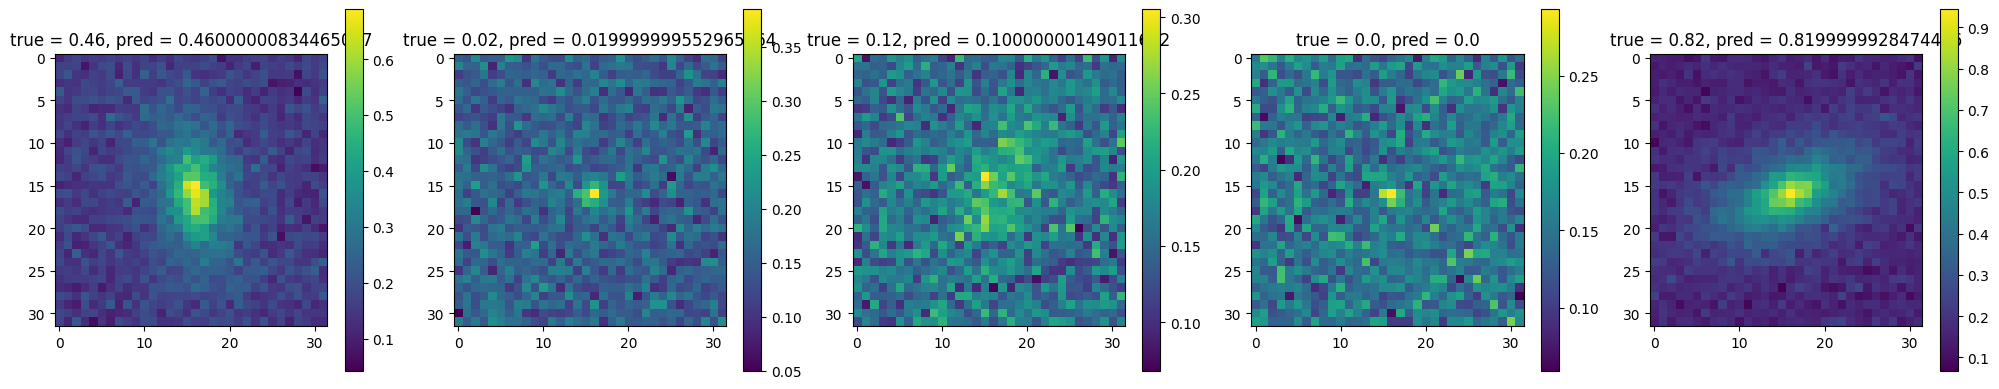

In [13]:
# Create a figure with 5 subplots in a horizontal row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figsize as needed

# Loop through each subplot
for i in range(5):
    ax = axes[i]
    ax.imshow(inputs_test[i, :, :], aspect='auto')
    ax.set_title(f'true = {round(outputs_test[i],2)}, pred = {round(y_pred[i,0],2)}')
    ax.figure.colorbar(ax.images[0], ax=ax)
    ax.set_aspect('equal')

# Show the complete figure
plt.tight_layout()
plt.savefig(f'../../../Desktop/validation_DER_{noise_level}_{inject_type}_{dim}.png', dpi=1000)

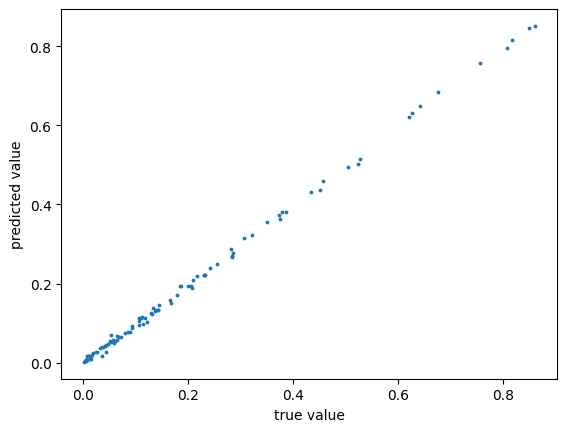

In [14]:
plt.scatter(
            outputs_test,
            y_pred[:, 0],
            #color=color_list[i],
            #label=r"$\sigma = $" + str(sigma_list[i]),
            s=3,
        )
plt.xlabel('true value')
plt.ylabel('predicted value');

Also create a way to overplot all three models at once, or perhaps plot three subplots?

noise is high, sigma is 1
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_2D_noise_low_loss_DER_COEFF_0.01_epoch_99.pt
example params [3.25831261 1.41486239 0.53044872]
example outputs 44.362711868999085
model outputs after normalization 0.006630372152428848
noise is high, sigma is 5
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_2D_noise_medium_loss_DER_COEFF_0.01_epoch_99.pt
example params [3.25831261 1.41486239 0.53044872]
example outputs 45.44252829411772
model outputs after normalization 0.008159890976442721
noise is high, sigma is 10
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_2D_noise_high_loss_DER_COEFF_0.01_epoch_99.pt
example params [3.25831261 1.41486239 0.53044872]
example outputs 34.35350223653558
model outputs after normalization 0.009319519672749204
noise is high, sigma is 0.17677669529663687
DER
loading this chk ../DeepUQResources/checkpoints/DER_

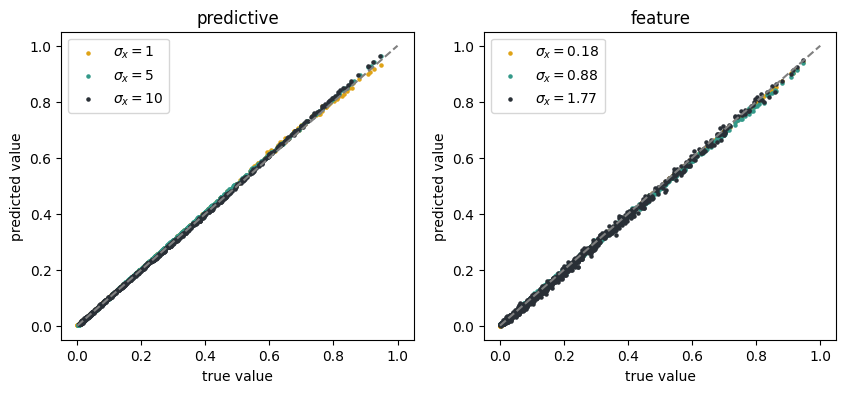

In [15]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise_level}, sigma is {sigma}")
        chk = checkpoints.load_checkpoint(
            "DER",
            "linear_homoskedastic",
            inject_type,
            dim,
            noise,
            99,
            DEVICE,
            path="../DeepUQResources/checkpoints/",
            loss="DER",
            COEFF=0.01
        )
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 1000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
            print('example params', data.params[0])
            print('example outputs', model_outputs[0])
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        print('model outputs after normalization', outputs_test[0])
        #continue
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                y_pred[:, 0],
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].plot([0,1],[0,1], ls='--', color='grey')
    axes[j].set_xlabel('true value')
    axes[j].set_ylabel('predicted value')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.savefig('../../../Desktop/validation_DER.png', dpi=1000)

Now look at residuals. (pred - true)

noise is high, sigma is 1
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_2D_noise_low_loss_DER_COEFF_0.01_epoch_99.pt
noise is high, sigma is 5
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_2D_noise_medium_loss_DER_COEFF_0.01_epoch_99.pt
noise is high, sigma is 10
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_2D_noise_high_loss_DER_COEFF_0.01_epoch_99.pt
noise is high, sigma is 0.17677669529663687
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_feature_2D_noise_low_loss_DER_COEFF_0.01_epoch_99.pt
noise is high, sigma is 0.8838834764831843
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_feature_2D_noise_medium_loss_DER_COEFF_0.01_epoch_99.pt
noise is high, sigma is 1.7677669529663687
DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_feature_2D_noise_high_loss_DER_COEFF_0.01_epoch_

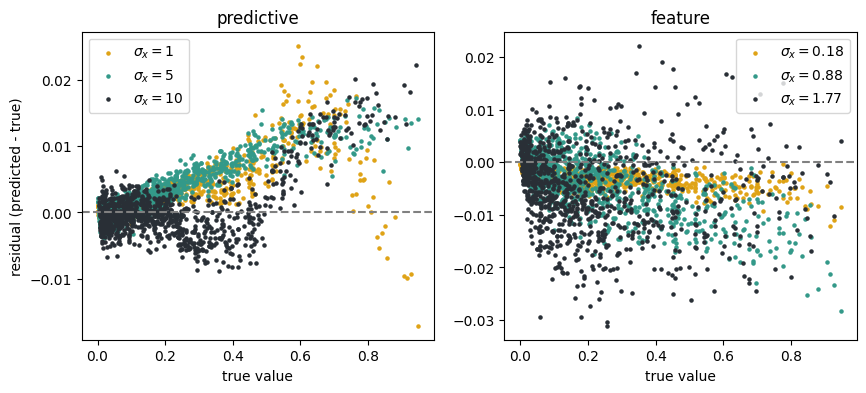

In [16]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise_level}, sigma is {sigma}")
        chk = checkpoints.load_checkpoint(
            "DER",
            "linear_homoskedastic",
            inject_type,
            dim,
            noise,
            99,
            DEVICE,
            path="../DeepUQResources/checkpoints/",
            loss="DER",
            COEFF=0.01
        )
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 1000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.savefig('../../../Desktop/residual_DER.png', dpi=1000)

## Look into if 10k images is necessary or if we can run with 1k.
I added a feature to 

noise is low, sigma is 1
noise is medium, sigma is 5
noise is high, sigma is 10
noise is low, sigma is 0.17677669529663687
noise is medium, sigma is 0.8838834764831843
noise is high, sigma is 1.7677669529663687


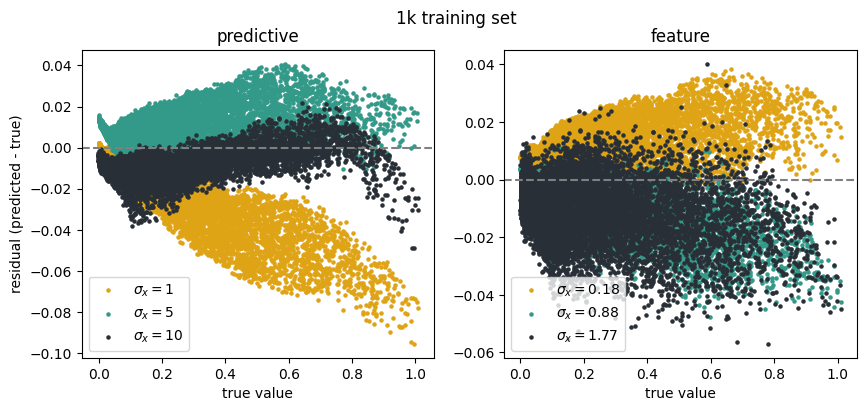

In [45]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    # noise_list = ["high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 1000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.suptitle('1k training set')
#plt.show()
plt.savefig('../../../Desktop/residual_DER_1k.png', dpi=1000)

noise is low, sigma is 1
noise is medium, sigma is 5
noise is high, sigma is 10
noise is low, sigma is 0.17677669529663687
noise is medium, sigma is 0.8838834764831843
noise is high, sigma is 1.7677669529663687


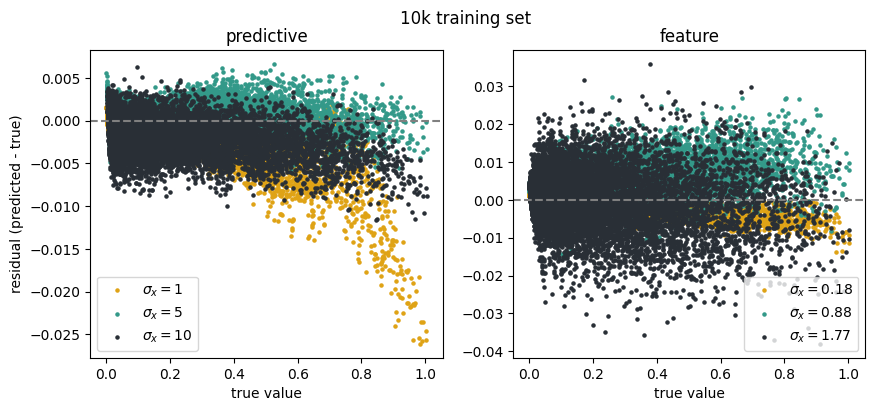

In [60]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 10000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.suptitle('10k training set')
#plt.show()
plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

## Also show error bars to put the residuals in context

noise is high, sigma is 10
noise is high, sigma is 1.7677669529663687


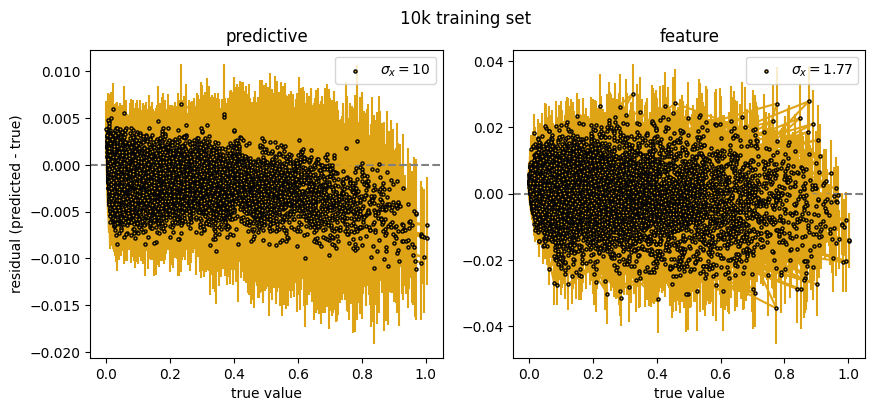

In [71]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["high"]#, "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 10000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        beta = y_pred[:, 3]
        nu = y_pred[:, 1]
        alpha = y_pred[:, 2]
        u_al = np.sqrt(
            beta
            * (1 + nu)
            / (alpha * nu)
        )
        axes[j].errorbar(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                yerr=u_al,
                color=color_list[i],
            )
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                edgecolor='black',
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
                zorder=100
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.suptitle('10k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

## I'd also like to plot loss for all of these training runs.

noise is low, sigma is 1
j 0
noise is medium, sigma is 5
j 0
noise is high, sigma is 10
j 0
noise is low, sigma is 0.17677669529663687
j 1
noise is medium, sigma is 0.8838834764831843
j 1
noise is high, sigma is 1.7677669529663687
j 1


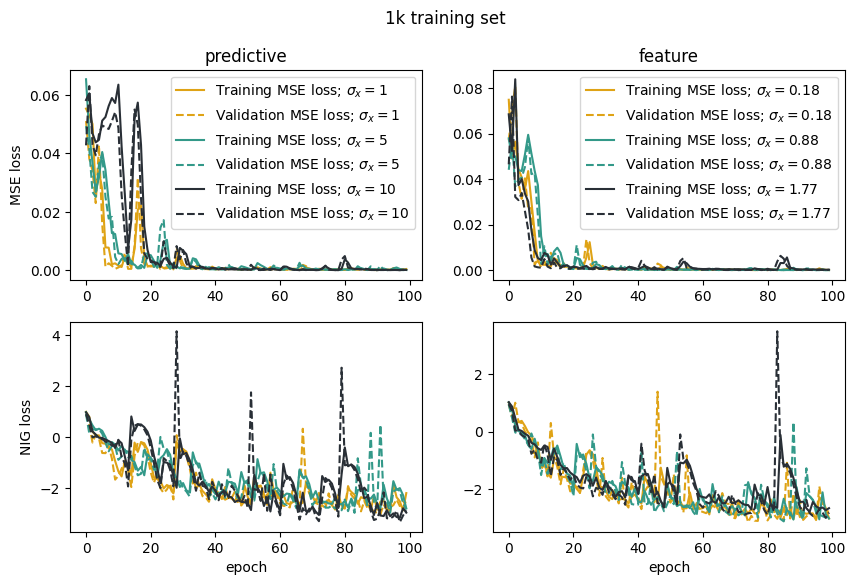

In [59]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss_name = "DER"
        COEFF = 0.01
        size_df = 1000
        n_epochs = 100
        mse_loss = []
        loss = []
        train_mse_loss = []
        train_loss = []
        for epoch in range(n_epochs):
            file_name = (
                str(path)
                + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
                + f"_noise_{noise}_loss_{loss_name}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            chk = torch.load(file_name, map_location=DEVICE)
            mse_loss.append(chk["valid_mse"])
            loss.append(chk["valid_loss"])
            train_mse_loss.append(chk["train_mse"])
            train_loss.append(chk["train_loss"])
        print('j', j)
        axes[j].plot(
                range(n_epochs),
                train_mse_loss,
                color=color_list[i],
                label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j].plot(
                range(n_epochs),
                mse_loss,
                color=color_list[i],
                label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                train_loss,
                color=color_list[i],
                label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                loss,
                color=color_list[i],
                label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        
    
    if j == 0:
        axes[j].set_ylabel('MSE loss') #/ true')
        axes[j+2].set_ylabel('NIG loss')
    axes[j].set_title(inject_type)
    axes[j].legend() 
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')
plt.suptitle('1k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

noise is low, sigma is 1
j 0
noise is medium, sigma is 5
j 0
noise is high, sigma is 10
j 0
noise is low, sigma is 0.17677669529663687
j 1
noise is medium, sigma is 0.8838834764831843
j 1
noise is high, sigma is 1.7677669529663687
j 1


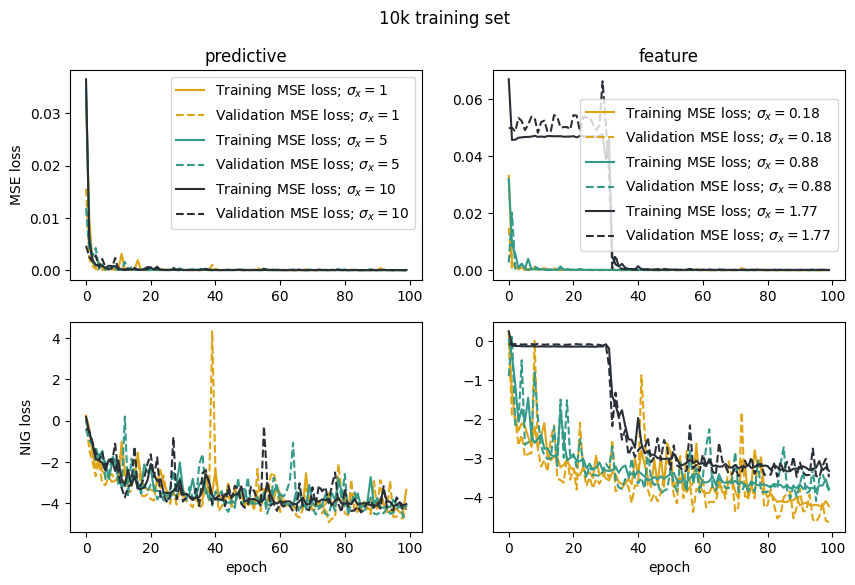

In [57]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss_name = "DER"
        COEFF = 0.01
        size_df = 10000
        n_epochs = 100
        mse_loss = []
        loss = []
        train_mse_loss = []
        train_loss = []
        for epoch in range(n_epochs):
            file_name = (
                str(path)
                + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
                + f"_noise_{noise}_loss_{loss_name}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            chk = torch.load(file_name, map_location=DEVICE)
            mse_loss.append(chk["valid_mse"])
            loss.append(chk["valid_loss"])
            train_mse_loss.append(chk["train_mse"])
            train_loss.append(chk["train_loss"])
        print('j', j)
        axes[j].plot(
                range(n_epochs),
                train_mse_loss,
                color=color_list[i],
                label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j].plot(
                range(n_epochs),
                mse_loss,
                color=color_list[i],
                label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                train_loss,
                color=color_list[i],
                label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                loss,
                color=color_list[i],
                label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        
    
    if j == 0:
        axes[j].set_ylabel('MSE loss') #/ true')
        axes[j+2].set_ylabel('NIG loss')
    axes[j].set_title(inject_type)
    axes[j].legend() 
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')
plt.suptitle('10k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)